In [1]:
suppressPackageStartupMessages(suppressWarnings({
    library("ggplot2")
    library(dplyr)
    library(tidyr)
    library(ComplexHeatmap)
    library(tibble)
}))


In [2]:
track_stats_file_path <- file.path("../data/combined_stats.parquet")
profile_file_path <- file.path("../../data/CP_feature_select/profiles/features_selected_profile.parquet")
# Read the profile data
profile <- arrow::read_parquet(profile_file_path, col_select = c("Metadata_dose", "Metadata_Well", "Metadata_FOV"))

profile$well_fov <- paste0(profile$Metadata_Well, "_F", profile$Metadata_FOV)
# arrange by well_fov
profile <- profile %>% arrange(well_fov) %>% 
    select(well_fov, Metadata_dose)
# remove duplicates
profile <- profile %>% 
    group_by(well_fov) %>% 
    summarise(Metadata_dose = unique(Metadata_dose)) %>% 
    ungroup()

track_stats <- arrow::read_parquet(track_stats_file_path) 
# add the dose information to the track stats from the profile data 
track_stats <- track_stats %>% 
    left_join(profile, by = c("well_fov" = "well_fov"), relationship ="many-to-many")
track_stats$cell_loss <- track_stats$total_CP_cells - track_stats$total_annotated_cells	
head(track_stats)

Metadata_time,well_fov,total_CP_cells,total_annotated_cells,Metadata_dose,cell_loss
<dbl>,<chr>,<int>,<int>,<dbl>,<int>
0,C-02_F0001,180,30,0,150
1,C-02_F0001,178,134,0,44
2,C-02_F0001,176,144,0,32
3,C-02_F0001,175,139,0,36
4,C-02_F0001,174,135,0,39
5,C-02_F0001,174,134,0,40


In [3]:
track_stats$Metadata_dose <- as.character(track_stats$Metadata_dose)
track_stats$Metadata_dose <- factor(
    track_stats$Metadata_dose, 
    levels = c(
        '0',
        '0.61',
        '1.22',
        '2.44',
        '4.88',
        '9.77',
        '19.53',
        '39.06',
        '78.13',
        '156.25'
    )
)
unique(track_stats$Metadata_dose)

[1] 0      0.61   1.22   2.44   4.88   9.77   19.53  39.06  78.13  156.25
Levels: 0 0.61 1.22 2.44 4.88 9.77 19.53 39.06 78.13 156.25

In [4]:
color_pallete_for_dose <- c(
    "0" = "#57F2F2",
    "0.61" = "#63D6D6",
    "1.22" = "#65BABA",
    "2.44" = "#68A3A3",
    "4.88" = "#668A8A",
    "9.76" = "#5E7070",
    "19.53" = "#4B5757",
    "39.06" = "#2F3D3D",
    "78.13" = "#182424",
    "156.25" = "#030A0A"
)

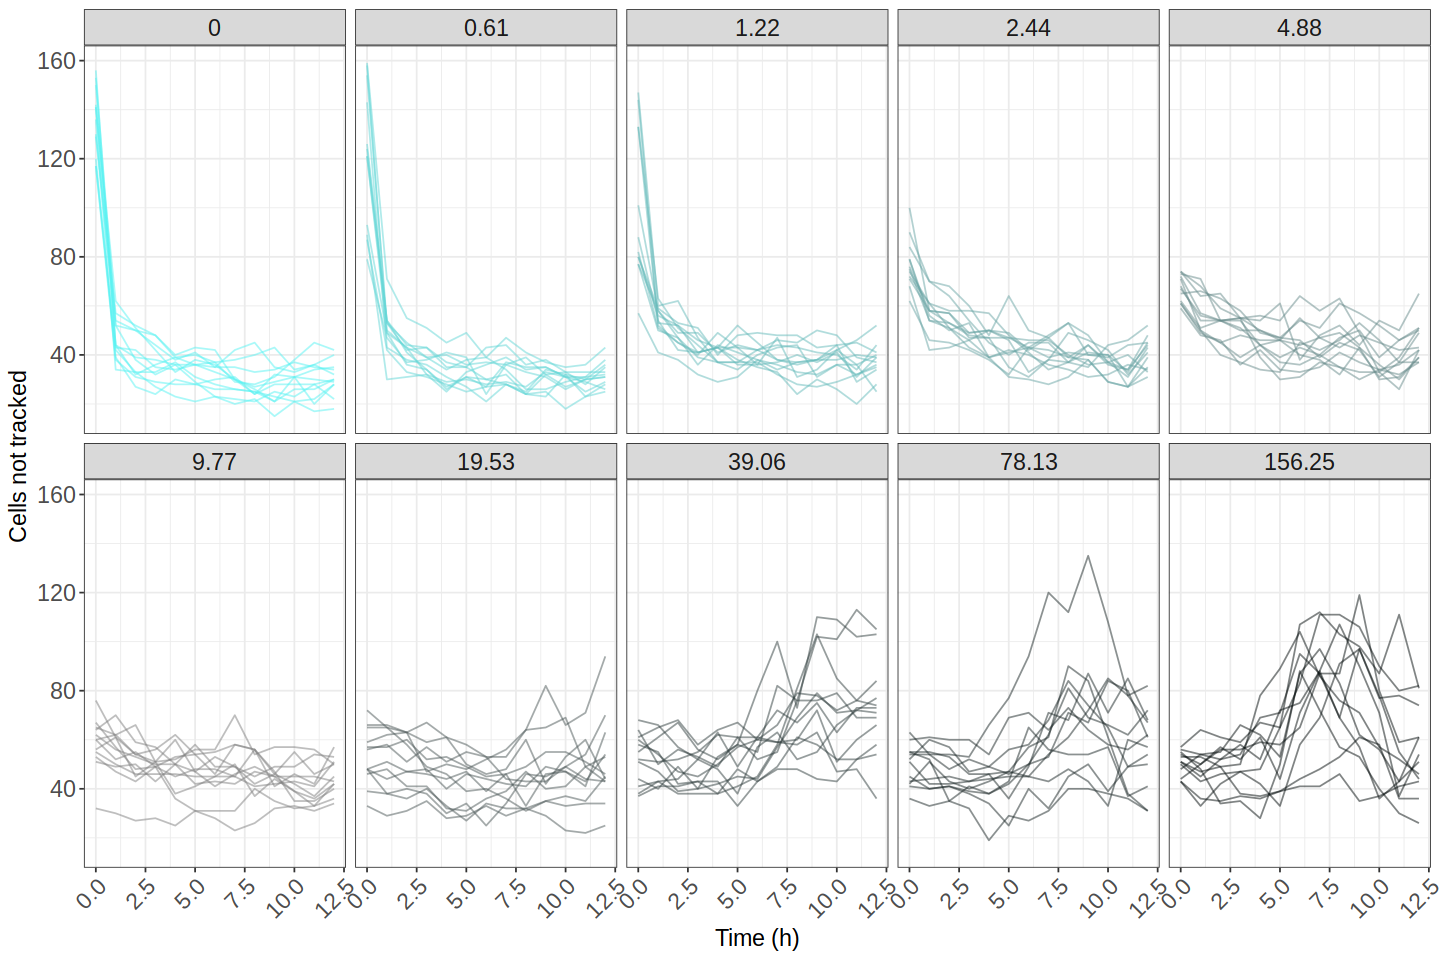

In [5]:
# plot over time the number of tracks
width <- 12
height <- 8
options(repr.plot.width = width, repr.plot.height = height)
temporal_tracks_plot <- (
    ggplot(track_stats, aes(x = Metadata_time, y = cell_loss, fill = Metadata_dose
))
    + geom_line(aes(group = well_fov, col= Metadata_dose), alpha = 0.5, linewidth = 0.5)
    + facet_wrap(~Metadata_dose, ncol = 5)
    + theme_bw()
    # add custom color palette
    + scale_color_manual(values = color_pallete_for_dose)
    + labs(
        x = "Time (h)",
        y = "Cells not tracked",
    )
    # legend title name change
    + guides(
        color = guide_legend(title = "Dose (nM)")
    )
    + theme(
        legend.position = "none",
        legend.title = element_text(size = 14),
        legend.text = element_text(size = 14),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14),
        axis.text.x = element_text(size = 14, angle = 45, hjust = 1),
        axis.text.y = element_text(size = 14),
        strip.text.x = element_text(size = 14
        )
    )
)
ggsave(
    filename = "temporal_tracks_plot.png",
    plot = temporal_tracks_plot,
    device = "png",
    path = "../figures/",
    width = width,
    height = height,
    units = "in",
    dpi = 600
)
temporal_tracks_plot